In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import datetime
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf
import statsmodels.api as sm
from matplotlib import pyplot as plt

/Users/Simran/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
import keras

ModuleNotFoundError: No module named 'keras'

Baseline Approach: Linear Regression Model is the simplest form of neural network, so it should be a good baseline model to compare other approaches too. I don't expect the dengue outbreaks to be modeled linearly from my prior understanding of epidemiology. I anticipate it to follow some sort of logistic model. Average temperature, city, year, week of year, and average precipitation are good baseline features to use. City, year, and week of year will provide sufficient information for time and place. As the spread of diseases is highly dependent on the number of already infected people, this information is vital for a successful model. Temperature and precipitation are valuable features as they are useful in predicting the amount of mosquitos in an area. The disease vector (female mosquito) like damp, warm environments so these features should be useful in predicting future dengue outbreaks. For the sake of example, we will have 3 hidden layers with 10, 20, and 10 neurons.

A good model to try to use is the Long Short Term Memory Model. The LSTM model is recurrent, meaning data is can flow forward and backward throughout the network making it useful to model situations where there are many time gaps between important events. These time gaps are characteristic of the data we have present for the dengue fever outbreaks. Also, since the model is recurrent, it can make good use of the time stamps we have and are more likely to accurately predict future outbreaks as the spread of disease is heavily dependent on variables such as number of previous cases in an area.

Since the female mosquito population is the disease vector for Dengue fever, you can naturally assume a connection between their population in an area and the prevalence of the disease. Finding the mosquito population in SJ and IQ over a certain period of time can be helpful in increasing the accuracy of the model. This information can be ideally downloaded from the internet. If not, it may be possible to create a feature that can be used to represent the population of mosquitos as a function of the mosquito's preferred environmental conditions such as humidity, temperature, water content, etc. Reducing these factors into one feature can also provide a way for you to control the weigiht of each individual individual factor. For example, weighting the temperature twice as much as other factors if you think that it is more important

Mosquitos are also daytime feeders so time of day may be important in determining the likelihood of infection. "The peak biting periods are early in the morning and in the evening before dusk." (from WHO) A rough estimate of time of day can be derived from information about the time of year given from the features. This can be used to create a "daytime" scale that can be used to represent different amounts of sunlight in a given time period. For example, summer has comparatively longer and hotter days and this may be used to complement temperature data as well.

In [398]:
total_labels = pd.read_csv('./input/dengue_labels_train.csv')
total_features = pd.read_csv('./input/dengue_features_train.csv')
total_test_features = pd.read_csv('./input/dengue_features_test.csv')
total_features = total_features.drop(total_features.index[[1456]], axis=0) 
total_labels = total_labels.drop(total_labels.columns[[0, 1, 2]], axis=1) 

In [399]:
print((total_features.columns.values.tolist()))

['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm']


In [325]:
remove = [0, 1, 2, 3, 4, 5, 6, 8, 7, 9, 10, 12, 14, 15, 16, 18, 19, 20, 21, 23]
total_test_features = total_test_features.drop(total_test_features.columns[remove], axis=1) 
total_features = total_features.drop(total_features.columns[remove], axis=1) 

In [400]:
total_features = total_features.fillna(method='ffill')
total_test_features = total_test_features.fillna(method='ffill')

In [326]:
print((total_features.columns.values.tolist()))

['reanalysis_dew_point_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_specific_humidity_g_per_kg', 'station_min_temp_c']


In [380]:
sj_test, iq_test = preprocess_data('./input/dengue_features_test.csv', None)

sj_predictions = sj_best_model.predict(sj_test).astype(int)
iq_predictions = iq_best_model.predict(iq_test).astype(int)

submission = pd.read_csv('./input/submission_format.csv',
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("./input/bench_submission.csv")

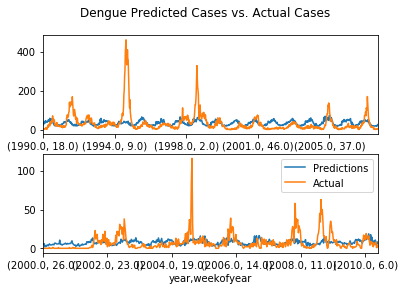

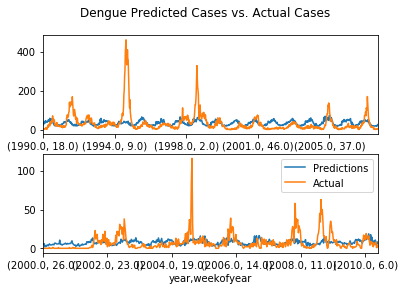

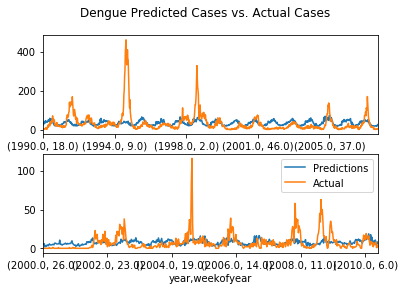

In [381]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_train['fitted'] = sj_best_model.fittedvalues
sj_train.fitted.plot(ax=axes[0], label="Predictions")
sj_train.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
iq_train['fitted'] = iq_best_model.fittedvalues
iq_train.fitted.plot(ax=axes[1], label="Predictions")
iq_train.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()
plt.show()

In [423]:
print((total_features.columns.values.tolist()))

['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm']


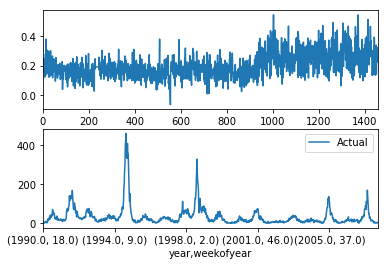

In [434]:
figs, axes = plt.subplots(nrows=2, ncols=1)
# station_diur_temp_rng_c, 
# plot sj
# print(sj_train['reanalysis_specific_humidity_g_per_kg'])

total_features.ndvi_sw.plot(ax=axes[0], label="...")

# sj_train.total_cases.plot(ax=axes[0], label="Actual")
# print(dir(sj_train))

sj_train.total_cases.plot(ax=axes[1], label="Actual")

# plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()
plt.show()

Testing for new features:

In [73]:
def normalize(column):
    new_column = []
    min_val = min(column)
    max_val = max(column)
    range_val = max_val-min_val
    for entry in column:
        new_column.append((entry-min_val)/range_val)
    return new_column

In [74]:
new_times = []
for entry in total_features['week_start_date']:
    entry = entry.split('/')
    if int(entry[2]) > 89:
        entry[2] = '19' + entry[2]
    else: entry[2] = '20' + entry[2]
    newtime = datetime.datetime(int(entry[2]), int(entry[0]), int(entry[1])).toordinal() - 726587
    new_times.append(newtime)
total_features['new_times'] = new_times
    
new_times = []
offset = datetime.datetime.strptime(total_test_features['week_start_date'][0], '%Y-%m-%d').toordinal()
for entry in total_test_features['week_start_date']:
    new_times.append(datetime.datetime.strptime(entry, '%Y-%m-%d').toordinal()-726587)
total_test_features['new_times'] = new_times

This next line is for new Mosquitio Amount feature. Comment it out and just use the line after that if you want just the baseline approach.

In [222]:
# total_features = total_features.drop(total_features.columns[[0, 3]], axis=1) 
# total_features = total_features.drop(total_features.index[[1456]], axis=0) 
# total_labels = total_labels.drop(total_labels.columns[[0, 1, 2]], axis=1) 
# total_test_features = total_test_features.drop(total_test_features.columns[[0, 3]], axis=1)
# total_features = total_features.apply(lambda x: x.fillna(x.mean()),axis=0)
# total_test_features = total_test_features.apply(lambda x: x.fillna(x.mean()),axis=0)
# new_feature = total_features['reanalysis_precip_amt_kg_per_m2']+(total_features['reanalysis_avg_temp_k']/25)+(total_features['reanalysis_relative_humidity_percent']/10)
# total_features['new'] = new_feature
# new_test_feature = total_test_features['reanalysis_precip_amt_kg_per_m2']+(total_test_features['reanalysis_avg_temp_k']/25)+(total_test_features['reanalysis_relative_humidity_percent']/10)
# total_test_features['new'] = new_test_feature

None


In [238]:
# remove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
# remove = [0, 1, 2, 3, 4, 5, 6, 7]
# remove_later = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
# benchmark features testing
remove = [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 17, 18, 20, 21, 23]
remove_later = []

total_features = total_features.drop(total_features.columns[[0, 1, 2, 3, 4, 6]], axis=1) 
total_test_features = total_test_features.drop(total_test_features.columns[remove], axis=1)
# total_features = total_features[['reanalysis_specific_humidity_g_per_kg', 
#                  'reanalysis_dew_point_temp_k', 
#                  'station_avg_temp_c', 
#                  'station_min_temp_c']]
# total_test_features = total_test_features[['reanalysis_specific_humidity_g_per_kg', 
#                  'reanalysis_dew_point_temp_k', 
#                  'station_avg_temp_c', 
#                  'station_min_temp_c']]
# total_features = total_features.apply(lambda x: x.fillna(x.mean()),axis=0)
# total_test_features = total_test_features.apply(lambda x: x.fillna(x.mean()),axis=0)

In [77]:
features_to_change = ['reanalysis_precip_amt_kg_per_m2', 'reanalysis_avg_temp_k', 'reanalysis_sat_precip_amt_mm', 'reanalysis_relative_humidity_percent']

In [78]:
for feature in features_to_change:
    new_train = normalize(total_features[feature])
    new_test = normalize(total_test_features[feature])
    total_features['new_'+feature] = new_train
    total_test_features['new_'+feature] = new_test

In [79]:
total_features = total_features.drop(total_features.columns[remove_later], axis=1) 
total_test_features = total_test_features.drop(total_test_features.columns[remove_later], axis=1)

In [289]:
print(total_features)

None


In [304]:
sj_features = total_features.loc[:935][:]
iq_features = total_features.loc[936:][:]
sj_labels = total_labels.loc[:935][:]
iq_labels = total_labels.loc[936:][:]
sj_test_features = total_test_features[:260][:]
iq_test_features = total_test_features[260:][:]

In [305]:
sj_x_train, sj_x_test, sj_y_train, sj_y_test = model_selection.train_test_split(sj_features, sj_labels, 
                                                                    test_size=0.2, random_state=42)
iq_x_train, iq_x_test, iq_y_train, iq_y_test = model_selection.train_test_split(iq_features, iq_labels, 
                                                                    test_size=0.2, random_state=42)

# You can switch between different models starting here.

In [229]:
sj_feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(sj_x_train)
iq_feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(iq_x_train)

In [230]:
sj_regressor = tf.contrib.learn.DNNRegressor(feature_columns=sj_feature_columns, 
                                            hidden_units=[10, 20, 10])
iq_regressor = tf.contrib.learn.DNNRegressor(feature_columns=iq_feature_columns, 
                                            hidden_units=[10, 20, 10])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11e284be0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': None}
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11bdb8f98>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1

In [231]:
sj_regressor.fit(sj_x_train, sj_y_train, steps=200)
iq_regressor.fit(iq_x_train, iq_y_train, steps=200)

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Sav

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x11cc01550>, 'hidden_units': [10, 20, 10], 'feature_columns': (_RealValuedColumn(column_name='', dimension=8, default_value=None, dtype=tf.float64, normalizer=None),), 'optimizer': None, 'activation_fn': <function relu at 0x10c1da6a8>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

In [232]:
predictions = list(sj_regressor.predict(sj_x_test, as_iterable=True))
score = metrics.mean_absolute_error(sj_y_test, predictions)
print('Loss: {0:f}'.format(score))

Instructions for updating:
Please switch to predict_scores, or set `outputs` argument.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Restoring parameters from /var/folders/3d/9yysmf897wj96_hjgtfwnjnw0000gn/T/tmpel27kh04/model.ckpt-200
Loss: 29.068241


In [233]:
predictions = list(iq_regressor.predict(iq_x_test, as_iterable=True))
score = metrics.mean_absolute_error(iq_y_test, predictions)
print('Loss: {0:f}'.format(score))

Instructions for updating:
Please switch to predict_scores, or set `outputs` argument.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Restoring parameters from /var/folders/3d/9yysmf897wj96_hjgtfwnjnw0000gn/T/tmpk4u1wnia/model.ckpt-200
Loss: 6.260020


In [240]:
sj_predictions = [int(round(i)) for i in list(sj_regressor.predict(sj_test_features))]
iq_predictions = [int(round(i)) for i in list(sj_regressor.predict(iq_test_features))]

submission = pd.read_csv('./input/submission_format.csv',
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv('./input/submission.csv')

(260, 8)
Instructions for updating:
Please switch to predict_scores, or set `outputs` argument.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Restoring parameters from /var/folders/3d/9yysmf897wj96_hjgtfwnjnw0000gn/T/tmpel27kh04/model.ckpt-200
Instructions for updating:
Please switch to predict_scores, or set `outputs` argument.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Restoring parameters from /var/folders/3d/9yysmf897wj96_hjgtfwnjnw0000gn/T/

# Multiple Layer Perceptron Model:

In [329]:
RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)

In [330]:
def init_weights(shape):
    weights = tf.random_normal(shape, stddev=0.1)
    return tf.Variable(weights)

In [331]:
def forwardprop(X, w_1, w_2):
    h = tf.nn.sigmoid(tf.matmul(X, w_1))  # The \sigma function
    yhat = tf.matmul(h, w_2)
    return yhat

In [332]:
def process_features(features, labels):
    # Prepend the column of 1s for bias
#     N, M  = features.shape
#     all_X = np.ones((N, M + 1))
#     all_X[:, 1:] = features
    all_X = features
    
#     # Convert into one-hot vectors
#     num_labels = len(np.unique(target))
#     all_Y = np.eye(num_labels)[target]  # One liner trick!
    return train_test_split(all_X, labels, test_size=0.33, random_state=RANDOM_SEED)

In [333]:
sj_train_X, sj_test_X, sj_train_y, sj_test_y = process_features(sj_features, sj_labels)
iq_train_X, iq_test_X, iq_train_y, iq_test_y = process_features(iq_features, iq_labels)

In [334]:
# Layer's sizes
x_size = sj_train_X.shape[1]
h_size = 256
y_size = sj_train_y.shape[1]

In [335]:
# Symbols
X = tf.placeholder("float", shape=[None, x_size])
y = tf.placeholder("float", shape=[None, y_size])

In [336]:
# Weight initializations
w_1 = init_weights((x_size, h_size))
w_2 = init_weights((h_size, y_size))

In [337]:
# Forward propagation
yhat    = forwardprop(X, w_1, w_2)
predict = tf.to_int64(yhat)

In [338]:
# Backward propagation
cost    = tf.losses.mean_squared_error(labels=y, predictions=yhat)
updates = tf.train.GradientDescentOptimizer(0.000001).minimize(cost)

In [339]:
print(sj_train_X)

     reanalysis_dew_point_temp_k  reanalysis_specific_humidity_g_per_kg
164                   296.294286                              17.712857
28                    295.687143                              17.085714
523                   294.554286                              15.918571
193                   293.721429                              15.097143
332                   296.880000                              18.407143
594                   296.957143                              18.475714
169                   296.592857                              18.034286
684                   296.352857                              17.754286
140                   294.150000                              15.520000
173                   296.490000                              17.917143
6                     295.865714                              17.234286
598                   296.687143                              18.155714
405                   295.628571                              17

In [340]:
# Run SGD
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

for epoch in range(100):
        # Train with each example
        for i in range(len(sj_train_X)):
            sess.run(updates, feed_dict={X: sj_train_X[i: i + 1], y: sj_train_y[i: i + 1]})
            
        train_accuracy = metrics.mean_absolute_error(sj_train_y, sess.run(predict, feed_dict={X: sj_train_X}))
        test_accuracy  = metrics.mean_absolute_error(sj_test_y, sess.run(predict, feed_dict={X: sj_test_X}))

        print("Epoch = %d, train loss = %.2f, test loss = %.2f"
              % (epoch + 1, train_accuracy, test_accuracy))
        
mlp_sj_predictions = sess.run(predict, feed_dict={X: sj_test_features})

Epoch = 1, train loss = 29.06, test loss = 30.94
Epoch = 2, train loss = 26.56, test loss = 28.46
Epoch = 3, train loss = 24.94, test loss = 26.85
Epoch = 4, train loss = 24.29, test loss = 26.16
Epoch = 5, train loss = 24.10, test loss = 25.95
Epoch = 6, train loss = 24.17, test loss = 26.04
Epoch = 7, train loss = 24.39, test loss = 26.28
Epoch = 8, train loss = 24.73, test loss = 26.62
Epoch = 9, train loss = 24.95, test loss = 26.82
Epoch = 10, train loss = 25.22, test loss = 27.04
Epoch = 11, train loss = 25.50, test loss = 27.28
Epoch = 12, train loss = 25.81, test loss = 27.54
Epoch = 13, train loss = 26.15, test loss = 27.82
Epoch = 14, train loss = 26.15, test loss = 27.82
Epoch = 15, train loss = 26.53, test loss = 28.13
Epoch = 16, train loss = 26.53, test loss = 28.13
Epoch = 17, train loss = 26.53, test loss = 28.13
Epoch = 18, train loss = 26.94, test loss = 28.47
Epoch = 19, train loss = 26.94, test loss = 28.47
Epoch = 20, train loss = 26.94, test loss = 28.47
Epoch = 2

In [341]:
# Run SGD
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
for epoch in range(100):
        # Train with each example
        for i in range(len(iq_train_X)):
            sess.run(updates, feed_dict={X: iq_train_X[i: i + 1], y: iq_train_y[i: i + 1]})
            
        train_accuracy = metrics.mean_absolute_error(iq_train_y, sess.run(predict, feed_dict={X: iq_train_X}))
        test_accuracy  = metrics.mean_absolute_error(iq_test_y, sess.run(predict, feed_dict={X: iq_test_X}))

        print("Epoch = %d, train loss = %.2f, test loss = %.2f"
              % (epoch + 1, train_accuracy, test_accuracy))
        
mlp_iq_predictions = sess.run(predict, feed_dict={X: iq_test_features})

Epoch = 1, train loss = 7.66, test loss = 7.37
Epoch = 2, train loss = 7.02, test loss = 6.76
Epoch = 3, train loss = 7.02, test loss = 6.76
Epoch = 4, train loss = 6.56, test loss = 6.34
Epoch = 5, train loss = 6.56, test loss = 6.34
Epoch = 6, train loss = 6.29, test loss = 6.06
Epoch = 7, train loss = 6.29, test loss = 6.06
Epoch = 8, train loss = 6.16, test loss = 5.92
Epoch = 9, train loss = 6.16, test loss = 5.92
Epoch = 10, train loss = 6.16, test loss = 5.92
Epoch = 11, train loss = 6.16, test loss = 5.92
Epoch = 12, train loss = 6.10, test loss = 5.94


KeyboardInterrupt: 

In [ ]:
submission = pd.read_csv('./input/submission_format.csv',
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([mlp_sj_predictions, mlp_iq_predictions])
submission.to_csv('./input/mlp_submission.csv')